# ML Facial recognition to detect mood and suggest songs accordingly

# Author: ```Mohammed Muqtader Ali```

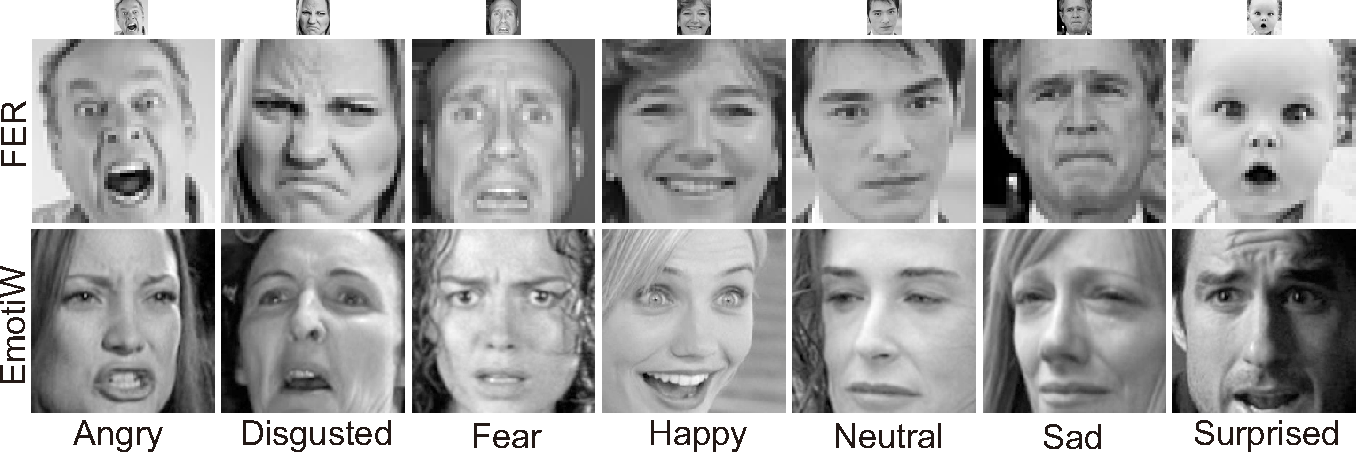!

Refer Dataset [here..](https://www.canva.com/link?target=https%3A%2F%2Fwww.kaggle.com%2Fmsambare%2Ffer2013&design=DAEjrwWV35w)

Facial expression for emotion detection has always been an easy task for humans, but achieving the same task with a computer algorithm is quite challenging. With the recent advancement in computer vision and machine learning, it is possible to detect emotions from images.

 In this project we use a technique called facial emotion recognition using convolutional neural networks **(FERC)**
 The FERC is based on two-part :-
 
 1. convolutional neural network (CNN): The first-part removes the background from the picture,
 2. The second part concentrates on the facial feature vector extraction

# Importing libraries

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

# Importing Dataset

In [3]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


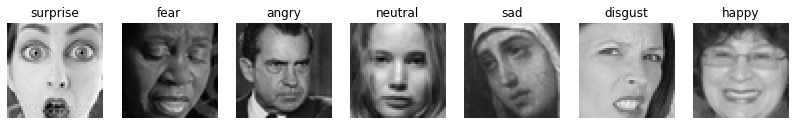

In [4]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

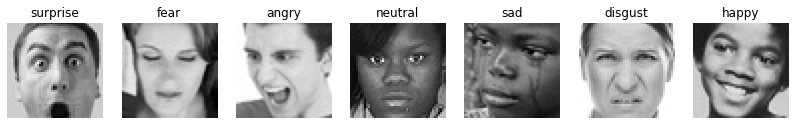

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(test_dir):
    img = load_img((test_dir + expression +'/'+ os.listdir(test_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# PLot of number of images in training set

<AxesSubplot:>

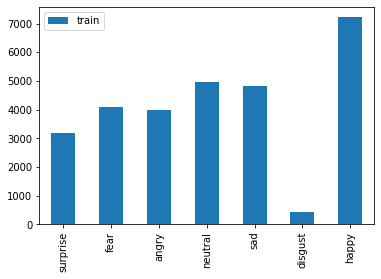

In [6]:
train_count.transpose().plot(kind='bar')

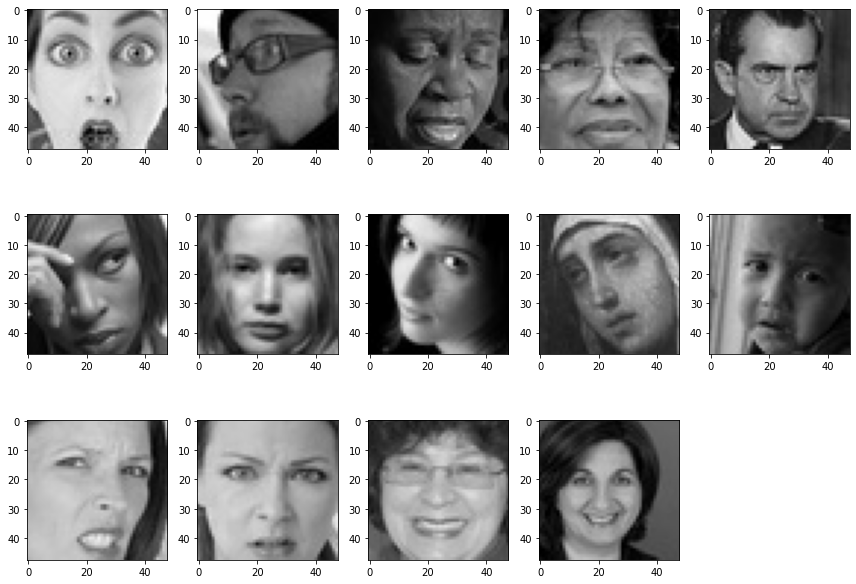

In [7]:
img_size = 48
plt.figure(0, figsize=(12,20))
index = 0
for link in os.listdir("../input/fer2013/train"):
    for i in range(1,3):
        index += 1
        plt.subplot(7,5,index)
        img = load_img("../input/fer2013/train/" + link + "/" +os.listdir("../input/fer2013/train/" + link)[i], target_size=(img_size, img_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()

# PLot of number of images in test set

<AxesSubplot:>

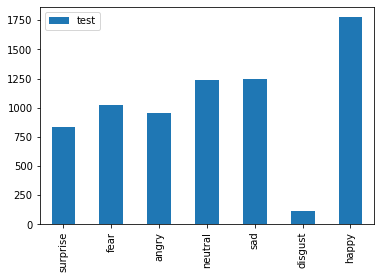

In [8]:
test_count.transpose().plot(kind='bar')

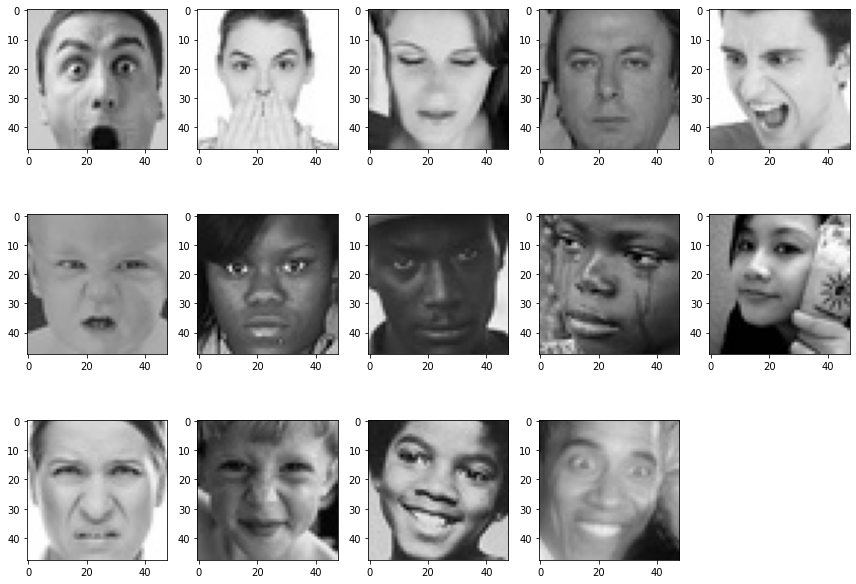

In [9]:
img_size = 48
plt.figure(0, figsize=(12,20))
index = 0
for link in os.listdir("../input/fer2013/test"):
    for i in range(1,3):
        index += 1
        plt.subplot(7,5,index)
        img = load_img("../input/fer2013/test/" + link + "/" +os.listdir("../input/fer2013/test/" + link)[i], target_size=(img_size, img_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()

# Creating Training and test sets

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [11]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# Defining Model

In [12]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [13]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

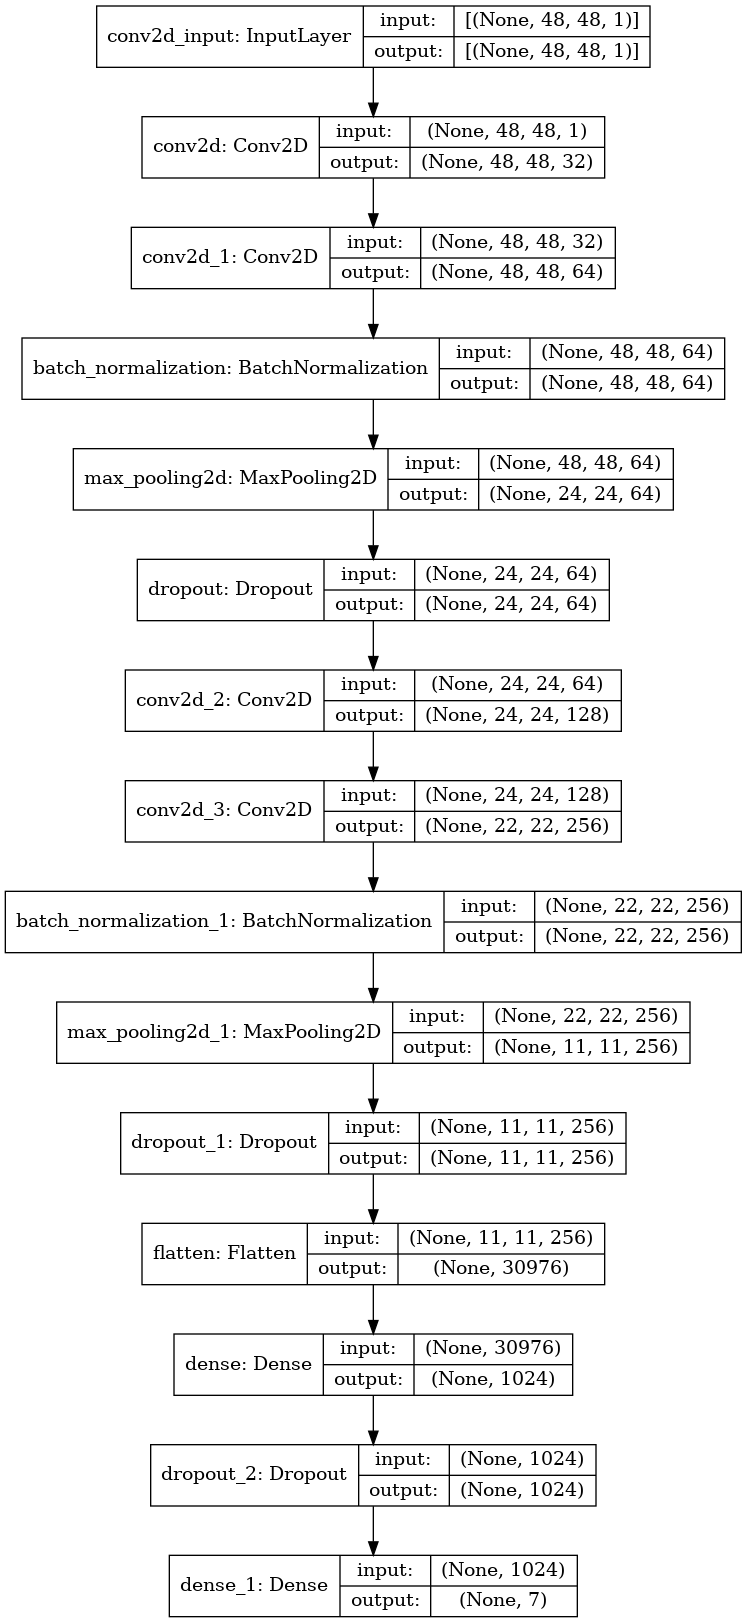

In [14]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

# Callbacks Function

In [15]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

# Training Model

In [16]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=10,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/10
448/448 [==============================] - 742s 2s/step - loss: 4.8551 - accuracy: 0.2426 - val_loss: 4.7522 - val_accuracy: 0.2460

Epoch 00001: val_loss improved from inf to 4.75218, saving model to ferNet.h5
Epoch 2/10
448/448 [==============================] - 734s 2s/step - loss: 3.6161 - accuracy: 0.3292 - val_loss: 3.1456 - val_accuracy: 0.4008

Epoch 00002: val_loss improved from 4.75218 to 3.14557, saving model to ferNet.h5
Epoch 3/10
448/448 [==============================] - 738s 2s/step - loss: 3.0617 - accuracy: 0.3721 - val_loss: 2.6568 - val_accuracy: 0.4178

Epoch 00003: val_loss improved from 3.14557 to 2.65678, saving model to ferNet.h5
Epoch 4/10
448/448 [==============================] - 755s 2s/step - loss: 2.6400 - accuracy: 0.3900 - val_loss: 2.2788 - val_accuracy: 0.4534

Epoch 00004: val_loss improved from 2.65678 to 2.27876, saving model to ferNet.h5
Epoch 5/10
448/448 [==============================] - 734s 2s/step - loss: 2.3091 - accuracy: 0.4194

# Loss and Accuracy plot

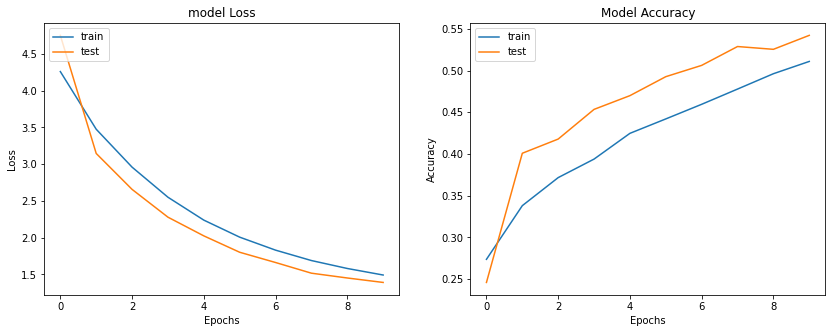

In [18]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model evaluation

In [19]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 40s 350ms/step - loss: 1.3914 - accuracy: 0.5419
final train accuracy = 54.24 , validation accuracy = 54.19


In [20]:
fernet.save_weights('fernet_bestweight.h5')

Confusion Matrix and Classification on training set

Confusion Matrix
[[ 264    3  326 1309  894  705  494]
 [  42    0   26  132  116   77   43]
 [ 345    1  313 1281  963  739  455]
 [ 572   11  560 2204 1717 1316  835]
 [ 375    7  382 1626 1176  858  541]
 [ 386    8  366 1482 1133  856  599]
 [ 217    7  223 1020  723  588  393]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.07      0.09      3995
     disgust       0.00      0.00      0.00       436
        fear       0.14      0.08      0.10      4097
       happy       0.24      0.31      0.27      7215
     neutral       0.17      0.24      0.20      4965
         sad       0.17      0.18      0.17      4830
    surprise       0.12      0.12      0.12      3171

    accuracy                           0.18     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.18      0.17     28709



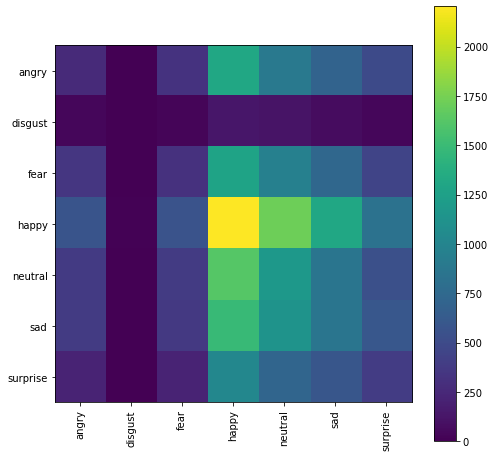

In [21]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix and Classification on test set

Confusion Matrix
[[ 89   1  92 279 231 140 126]
 [ 14   0  10  24  28  23  12]
 [ 96   2  87 283 248 164 144]
 [169   2 149 529 423 249 253]
 [113   1 107 359 280 195 178]
 [ 95   1  95 375 295 179 207]
 [ 65   1  87 258 186 117 117]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.09      0.11       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.08      0.11      1024
       happy       0.25      0.30      0.27      1774
     neutral       0.17      0.23      0.19      1233
         sad       0.17      0.14      0.15      1247
    surprise       0.11      0.14      0.13       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178



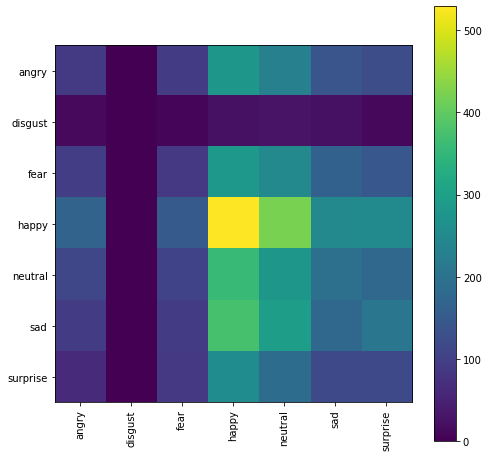

In [22]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)